In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [4]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ["tanh", "tanh"], names = names, labels = labels, ranges = ranges)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 63)                3213      
Total params: 6,063
Trainable params: 6,063
Non-trainable params: 0
_________________________________________________________________


Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 6s 143us/step - loss: 69.0654 - val_loss: 69.0776
Epoch 2/50
45000/45000 [==============================] - 3s 76us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 3/50
45000/45000 [==============================] - 3s 77us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 4/50
45000/45000 [==============================] - 3s 76us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 5/50
45000/45000 [==============================] - 3s 77us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 6/50
45000/45000 [==============================] - 3s 76us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 7/50
45000/45000 [==============================] - 3s 76us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 8/50
45000/45000 [==============================] - 3s 77us/step - loss: 69.0776 - val_loss: 69.0776
Epoch 9/50
45000/45000 [=

/Users/charnock/Physics/delfi/ndes/nde.py:249: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)) == True:
/Users/charnock/Physics/delfi/ndes/nde.py:252: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/mcsamples.py:1691: RuntimeWarning: divide by zero encountered in true_divide
  bins2D /= a00
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/mcsamples.py:1691: RuntimeWarning: invalid value encountered in true_divide
  bins2D /= a00
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


DensitiesError: Contour level outside plotted ranges

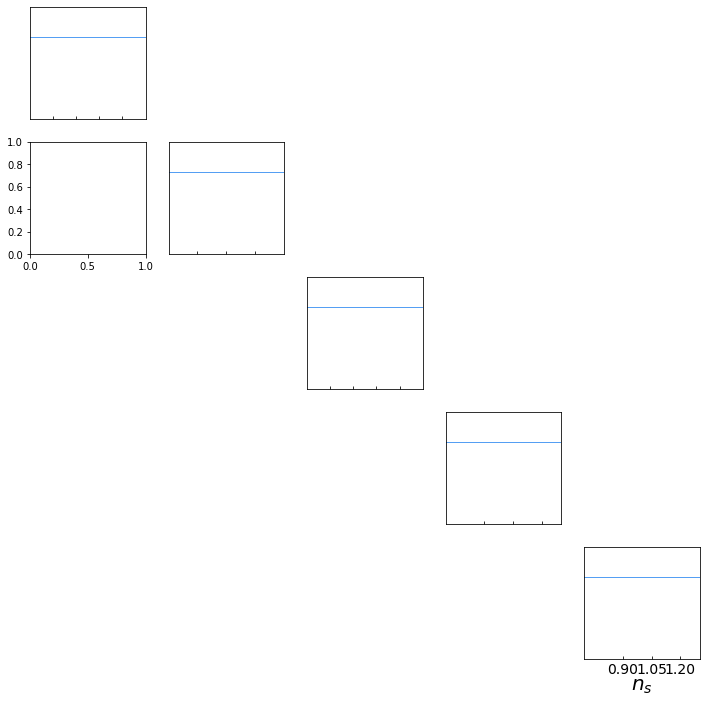

In [8]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=50)

Running initial 500 sims...
Simulator returns exception for parameter values: [0.28098733 0.7927824  0.0569505  0.68155833 1.03160421] (rank 0)
Simulator returns exception for parameter values: [0.30173717 0.80252345 0.02227135 0.51068163 0.98452062] (rank 0)
Simulator returns exception for parameter values: [0.29847004 0.79865698 0.08487051 0.92661356 0.92735564] (rank 0)
Simulator returns exception for parameter values: [0.30180366 0.79251872 0.02418239 0.58471256 1.0003829 ] (rank 0)
Simulator returns exception for parameter values: [0.30109088 0.80328685 0.06533983 0.82780249 0.92021888] (rank 0)
Simulator returns exception for parameter values: [0.28579407 0.79569908 0.0364961  0.75218647 0.91982518] (rank 0)
Simulator returns exception for parameter values: [0.28318337 0.79945389 0.05427471 0.78107228 0.94023173] (rank 0)
Simulator returns exception for parameter values: [0.30569253 0.79942779 0.00936411 0.48689328 0.98287976] (rank 0)
Simulator returns exception for parameter va

Simulator returns exception for parameter values: [0.30316281 0.79774375 0.02395484 0.71991917 0.89803235] (rank 0)
Simulator returns exception for parameter values: [0.29413061 0.80407598 0.03381405 0.55971525 0.98721983] (rank 0)
Simulator returns exception for parameter values: [0.30485781 0.79463539 0.06296319 0.78926739 0.95728144] (rank 0)
Simulator returns exception for parameter values: [0.29028877 0.80431358 0.03038487 0.62126648 0.95261452] (rank 0)
Simulator returns exception for parameter values: [0.3071867  0.79774157 0.064165   0.8579921  0.89710693] (rank 0)
Simulator returns exception for parameter values: [0.30338203 0.79783444 0.01758039 0.41209358 1.03817881] (rank 0)
Simulator returns exception for parameter values: [0.29448312 0.79937025 0.05564894 0.76041664 0.94553869] (rank 0)
Simulator returns exception for parameter values: [0.31263783 0.79456288 0.06023898 0.74228861 0.97735687] (rank 0)
Simulator returns exception for parameter values: [0.31175347 0.80158486

Simulator returns exception for parameter values: [0.29405239 0.80006454 0.02136527 0.50850811 1.00594981] (rank 0)
Simulator returns exception for parameter values: [0.29543414 0.80239118 0.02464701 0.47105182 1.02734929] (rank 0)
Simulator returns exception for parameter values: [0.29494626 0.796865   0.01921778 0.51008441 1.0150119 ] (rank 0)
Simulator returns exception for parameter values: [0.30033205 0.80345209 0.00450844 0.41992153 1.00107622] (rank 0)
Simulator returns exception for parameter values: [0.28963728 0.79936165 0.00854695 0.43822142 1.01949417] (rank 0)
Simulator returns exception for parameter values: [0.31353096 0.80027983 0.07083486 0.75224428 0.98239171] (rank 0)
Simulator returns exception for parameter values: [0.28432786 0.79729408 0.02003138 0.61182779 0.9572125 ] (rank 0)
Simulator returns exception for parameter values: [0.30148351 0.79928524 0.08734877 0.7992378  0.99438944] (rank 0)
Simulator returns exception for parameter values: [0.29763179 0.79732791

Simulator returns exception for parameter values: [0.30650301 0.79945019 0.04791088 0.66614316 0.96775434] (rank 0)
Simulator returns exception for parameter values: [0.30890136 0.80160931 0.01810097 0.55240646 0.96094494] (rank 0)
Simulator returns exception for parameter values: [0.29600745 0.79774637 0.07472964 0.86871392 0.92669292] (rank 0)
Simulator returns exception for parameter values: [0.30207503 0.80088686 0.04664834 0.60926849 0.99221328] (rank 0)
Simulator returns exception for parameter values: [0.3135416  0.80183916 0.04361129 0.64872958 0.9501941 ] (rank 0)
Simulator returns exception for parameter values: [0.29999116 0.79930918 0.01192481 0.55257281 0.95788407] (rank 0)
Simulator returns exception for parameter values: [0.28737494 0.79793786 0.00369512 0.50508837 0.97912744] (rank 0)
Simulator returns exception for parameter values: [0.30161615 0.80029392 0.01027148 0.4601182  0.99057048] (rank 0)
Simulator returns exception for parameter values: [0.28392779 0.79969549

Simulator returns exception for parameter values: [0.28492776 0.7951074  0.05393472 0.82360175 0.91996353] (rank 0)
Simulator returns exception for parameter values: [0.28796763 0.797461   0.07624488 0.85986999 0.94239321] (rank 0)
Simulator returns exception for parameter values: [0.29742131 0.79471244 0.06781389 0.82123395 0.94873198] (rank 0)
Simulator returns exception for parameter values: [0.30296097 0.79936472 0.02935233 0.57332892 0.98337802] (rank 0)
Simulator returns exception for parameter values: [0.30938691 0.80011732 0.08551375 0.92540093 0.90536819] (rank 0)
Simulator returns exception for parameter values: [0.30673097 0.79497115 0.05123151 0.67633812 0.9898378 ] (rank 0)
Simulator returns exception for parameter values: [2.80628256e-01 7.94782375e-01 1.17585567e-04 4.59050435e-01
 1.01691782e+00] (rank 0)
Simulator returns exception for parameter values: [0.29896518 0.79784441 0.0771317  0.82195249 0.96523119] (rank 0)
Simulator returns exception for parameter values: [

Simulator returns exception for parameter values: [0.31241952 0.80213484 0.03660109 0.50390011 1.02704797] (rank 0)
Simulator returns exception for parameter values: [0.30401559 0.799475   0.04988214 0.78896269 0.90806561] (rank 0)
Simulator returns exception for parameter values: [0.29179435 0.80290505 0.0950021  0.8142827  1.00076827] (rank 0)
Simulator returns exception for parameter values: [0.30218542 0.79167743 0.09105536 0.92960616 0.94890967] (rank 0)
Simulator returns exception for parameter values: [0.26366468 0.7950032  0.05718639 0.86804167 0.92086694] (rank 0)
Simulator returns exception for parameter values: [0.3021496  0.79843196 0.00811649 0.48965811 0.98293507] (rank 0)
Simulator returns exception for parameter values: [0.29761828 0.80161877 0.03117026 0.54761819 0.98221907] (rank 0)
Simulator returns exception for parameter values: [0.30944664 0.79984656 0.08600813 0.85258589 0.95239248] (rank 0)
Simulator returns exception for parameter values: [0.28875372 0.79782753

Simulator returns exception for parameter values: [0.31361816 0.80201574 0.0575006  0.72535088 0.94797228] (rank 0)
Simulator returns exception for parameter values: [0.29609682 0.80232365 0.01594391 0.49647416 0.98484679] (rank 0)
Simulator returns exception for parameter values: [0.2807642  0.80651907 0.01024137 0.54611711 0.9530667 ] (rank 0)
Simulator returns exception for parameter values: [0.29627176 0.801473   0.06542047 0.78533213 0.94573835] (rank 0)
Simulator returns exception for parameter values: [0.29470984 0.79515022 0.09851092 0.97602612 0.9484685 ] (rank 0)
Simulator returns exception for parameter values: [0.31670768 0.80142021 0.04753592 0.71792814 0.92145   ] (rank 0)
Simulator returns exception for parameter values: [0.30605746 0.79684695 0.08338404 0.88482569 0.93421103] (rank 0)
Simulator returns exception for parameter values: [0.29238646 0.79838519 0.02270116 0.69993465 0.9037902 ] (rank 0)
Simulator returns exception for parameter values: [0.30293778 0.80685332

Simulator returns exception for parameter values: [0.27644549 0.80123625 0.02330626 0.56014996 0.97703505] (rank 0)
Simulator returns exception for parameter values: [0.29118127 0.79661729 0.02277039 0.59122013 0.98208237] (rank 0)
Simulator returns exception for parameter values: [0.3009997  0.80289579 0.07272242 0.83584041 0.92491484] (rank 0)
Simulator returns exception for parameter values: [0.28410321 0.79692828 0.06267374 0.87159124 0.92013878] (rank 0)
Simulator returns exception for parameter values: [0.31830332 0.80562895 0.02818606 0.44390717 1.02578896] (rank 0)
Simulator returns exception for parameter values: [0.29583508 0.80053438 0.04900154 0.74019341 0.93182327] (rank 0)
Simulator returns exception for parameter values: [0.29757571 0.80047852 0.02329982 0.59719579 0.95203332] (rank 0)
Simulator returns exception for parameter values: [0.29168149 0.79778115 0.03939275 0.78997228 0.89151431] (rank 0)
Simulator returns exception for parameter values: [0.2964827  0.80013667

Simulator returns exception for parameter values: [0.29346126 0.79596621 0.05441956 0.8126062  0.92894418] (rank 0)
Simulator returns exception for parameter values: [0.29559073 0.80149751 0.0238148  0.49869352 1.01564063] (rank 0)
Simulator returns exception for parameter values: [0.30719474 0.79450598 0.05506585 0.65205754 1.00698384] (rank 0)
Simulator returns exception for parameter values: [0.30039115 0.79936039 0.0138161  0.46218394 1.01763189] (rank 0)
Simulator returns exception for parameter values: [0.33577343 0.80095929 0.02179898 0.59742234 0.92832877] (rank 0)
Simulator returns exception for parameter values: [0.2982891  0.79902883 0.06665161 0.86096768 0.91195642] (rank 0)
Simulator returns exception for parameter values: [0.29726946 0.8009901  0.0203212  0.69460349 0.89779703] (rank 0)
Simulator returns exception for parameter values: [0.31261342 0.80492139 0.03964232 0.59666911 0.97158482] (rank 0)
Simulator returns exception for parameter values: [0.31226969 0.80064304

450/450 [==============================] - 0s 94us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 2/100
450/450 [==============================] - 0s 75us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 3/100
450/450 [==============================] - 0s 51us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 4/100
450/450 [==============================] - 0s 48us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 5/100
450/450 [==============================] - 0s 47us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 6/100
450/450 [==============================] - 0s 70us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 7/100
450/450 [==============================] - 0s 51us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 8/100
450/450 [==============================] - 0s 61us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 9/100
450/450 [==============================] - 0s 71us/step - loss: 69.0776 - val_loss: 69.0775
Epoch 10/100
450/450 [==============================] - 0s 75us/step - loss:

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/_multivariate.py:462: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(np.dot(dev, prec_U)), axis=-1)


Done.


/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/chains.py:334: RuntimeWarning: overflow encountered in square
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:130: RuntimeWarning: overflow encountered in double_scalars
  auto[0] = xt[0] ** 2
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:131: RuntimeWarning: overflow encountered in double_scalars
  auto[-1] = xt[-1] ** 2
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:132: RuntimeWarning: overflow encountered in square
  auto[1:-1] = (xt[1:-2:2] ** 2 + xt[2:-1:2] ** 2)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/chains.py:488: RuntimeWarning: overflow encountered in square
  return np.dot(self.mean_diff(paramVec) ** 2, self.weights) / self.get_norm()
/Users/charnock/.pyenv/versions

ValueError: cannot convert float NaN to integer

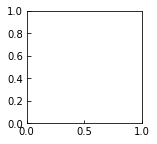

In [9]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

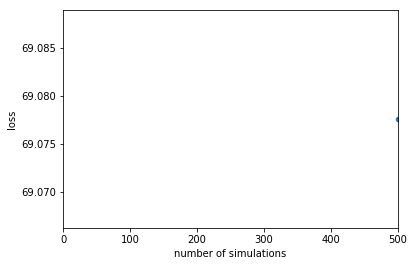

In [10]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()